In [3]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D

img_width, img_height = 128, 128

# build the VGG16 network
model = Sequential()
model.add(ZeroPadding2D((1, 1), batch_input_shape=(1, 3, img_width, img_height)))
first_layer = model.layers[-1]
# this is a placeholder tensor that will contain our generated images
input_img = first_layer.input

# build the rest of the network
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])

print(list(i for i in layer_dict.iterkeys() if 'conv' in i))

import h5py

weights_path = 'vgg16_weights.h5'

f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

['conv2_1', 'conv1_1', 'conv1_2', 'conv5_1', 'conv5_3', 'conv5_2', 'conv4_1', 'conv4_2', 'conv4_3', 'conv3_3', 'conv3_1', 'conv2_2', 'conv3_2']
Model loaded.


Now let's define a loss function that will seek to maximize the activation of a specific filter (filter_index) in a specific layer (layer_name). We do this via a Keras backend function, which allows our code to run both on top of TensorFlow and Theano. This is useful because TensorFlow has much faster convolutions on CPU, while Theano has somewhat faster convolutions on GPU at the moment: this allows us to pick the right backend based on our environment, without any changes in our code.

In [7]:
from keras import backend as K
import numpy as np

def deprocess_image(x):
    """util function to convert a tensor into a valid image"""
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


CPU times: user 46.9 s, sys: 3.72 s, total: 50.6 s
Wall time: 9.13 s


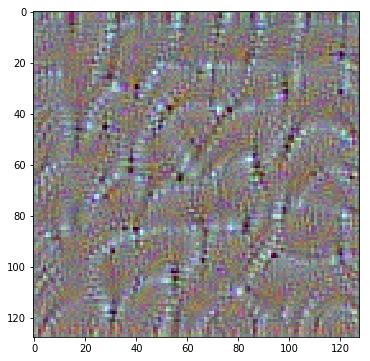

In [10]:
%%time
def show_filter(layer_name, filter_index):
    # build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    loss = K.mean(layer_output[:, filter_index, :, :])

    # compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # Now we can use the Keras function we defined to do gradient ascent in 
    # the input space, with regard to our filter activation loss:

    # we start from a gray image with some noise
    input_img_data = np.random.random((1, 3, img_width, img_height)) * 20 + 128.

    step = 1.

    # run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

   
    img = input_img_data[0]
    return deprocess_image(img)
    
im = show_filter('conv5_1', 0)

# from scipy.misc import imsave
# imsave('%s_filter_%d.png' % (layer_name, filter_index), img)
plt.figure("Figure", figsize=(12,6))
plt.imshow(im)

CPU times: user 4min, sys: 3.29 s, total: 4min 3s
Wall time: 1min


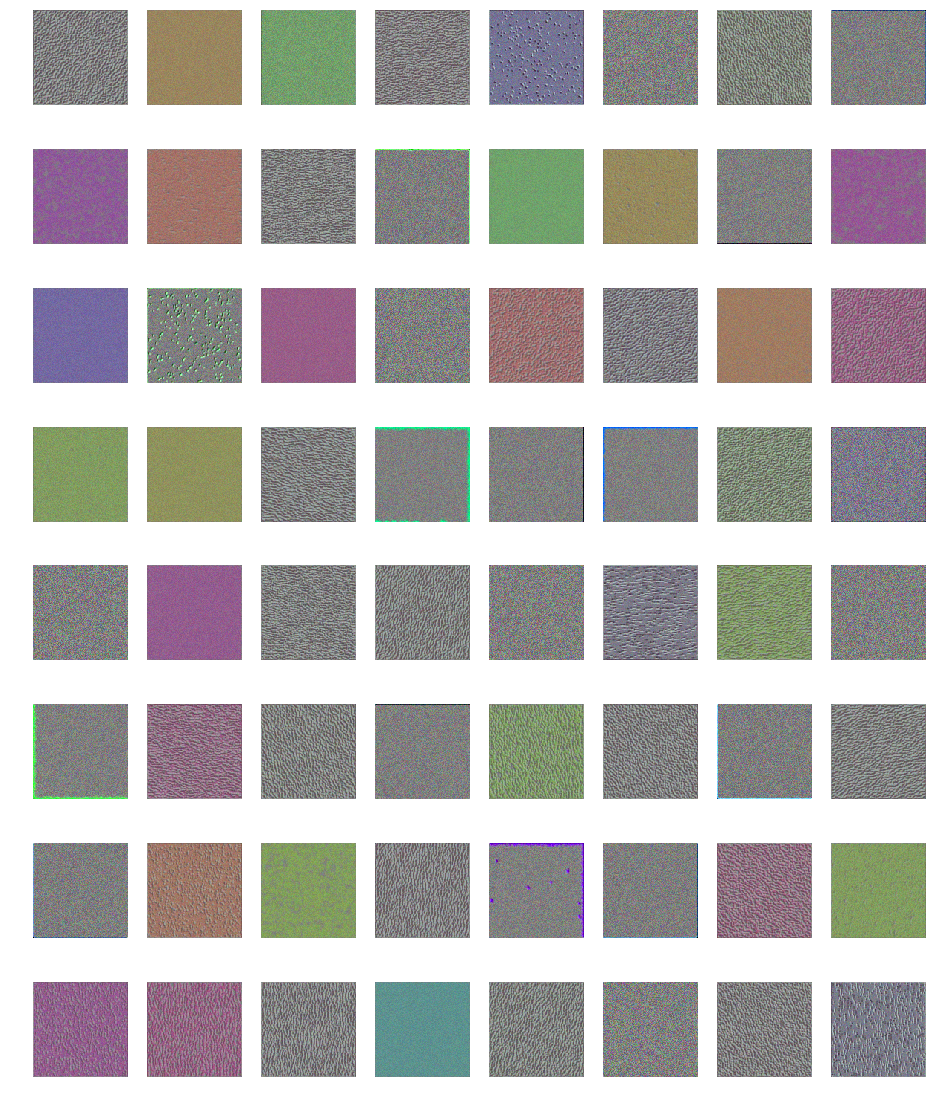

In [30]:
%%time

def mysqrt(n):
    a = np.sqrt(n)
    return int(a if int(a**2)==n else a+1)

def show_filters(layer_name):
    N = mysqrt(layer_dict[layer_name].nb_filter)
    plt.figure("Figure", figsize=(16,20))
    for i in xrange(layer_dict[layer_name].nb_filter):
        plt.subplot(N,N,i+1)
        plt.axis('off')
        plt.imshow(show_filter(layer_name, i))
    plt.savefig(layer_name+'.png')

# show_filters('conv1_1')

Exporting conv1_1 ...
Exporting conv1_2 ...
Exporting conv2_1 ...
Exporting conv2_2 ...
Exporting conv3_1 ...
Exporting conv3_2 ...
Exporting conv3_3 ...
Exporting conv4_1 ...
Exporting conv4_2 ...
Exporting conv4_3 ...
Exporting conv5_1 ...
Exporting conv5_2 ...
Exporting conv5_3 ...


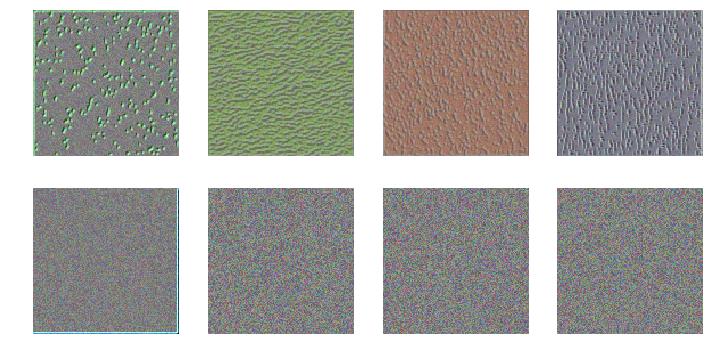

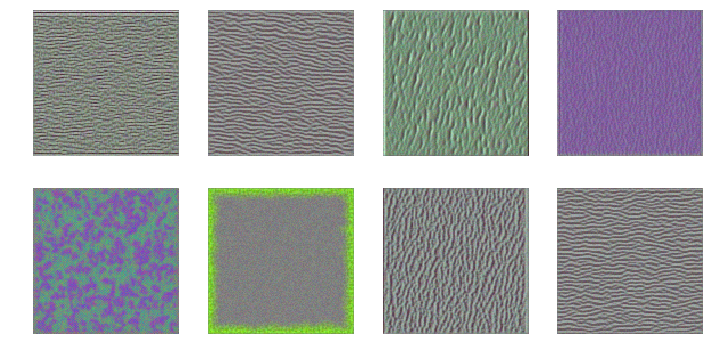

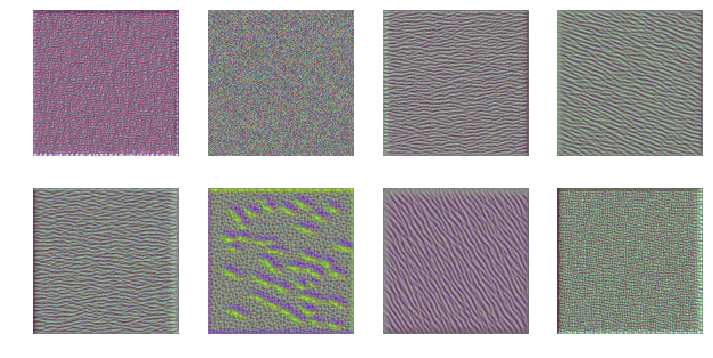

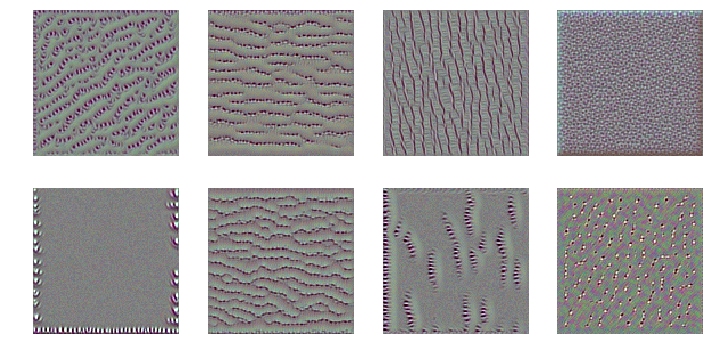

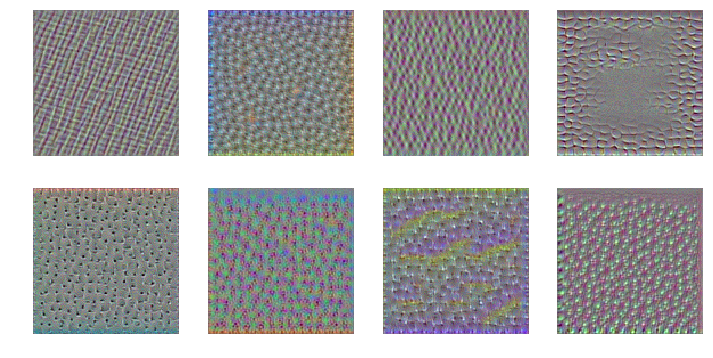

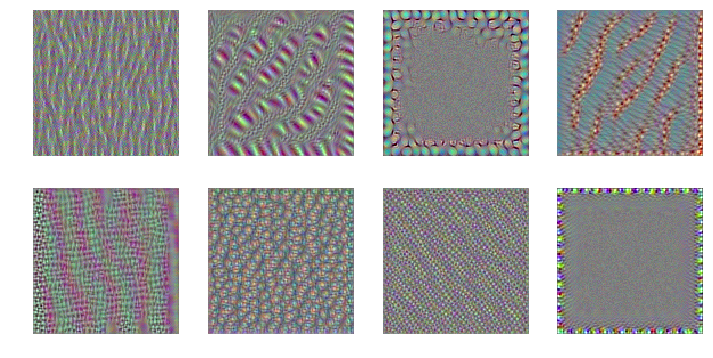

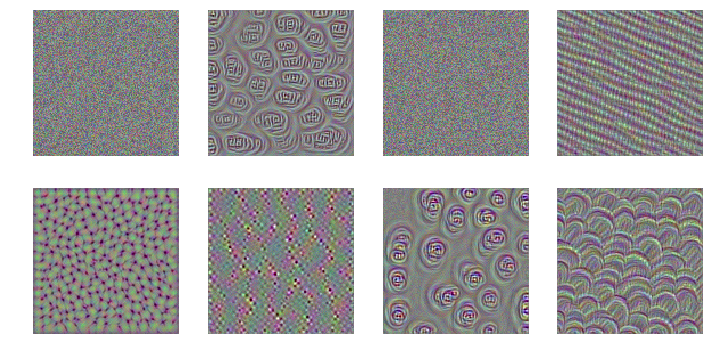

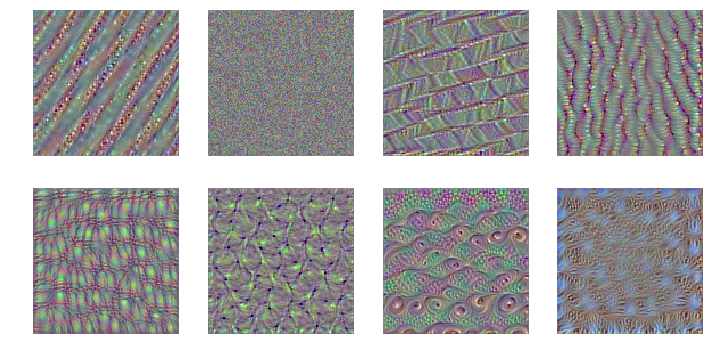

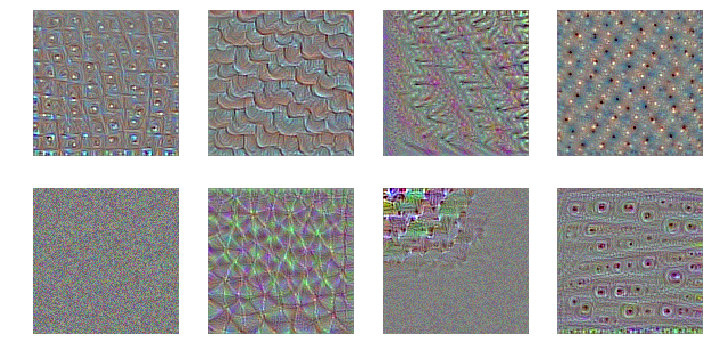

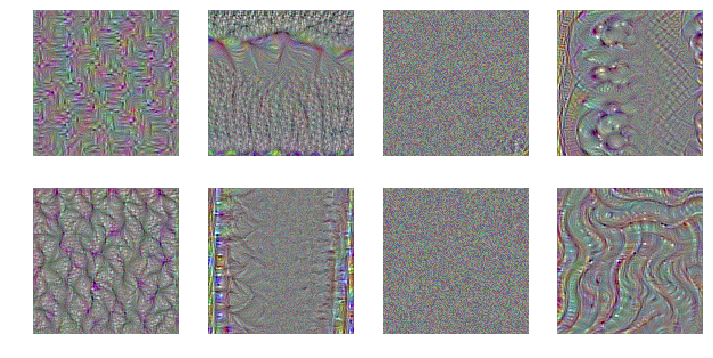

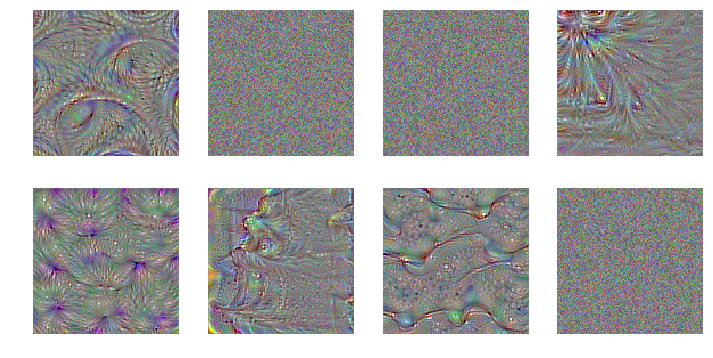

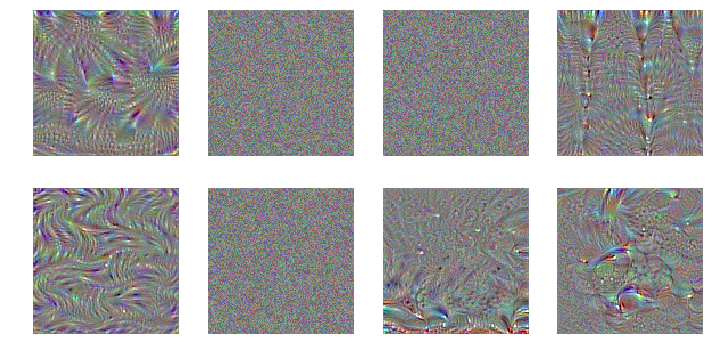

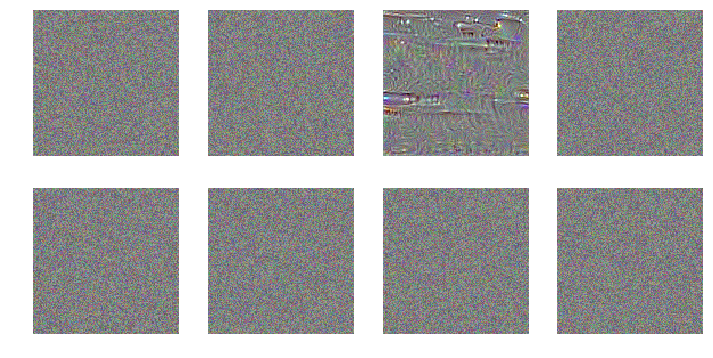

In [38]:
def _export_filters(layer_name):
    print('Exporting', layer_name, '...')
    plt.figure(layer_name, figsize=(12,6))
    sample = np.random.choice(range(layer_dict[layer_name].nb_filter), 8, False)
    for i in xrange(8):
        plt.subplot(2,4,i+1)
        plt.axis('off')
        plt.imshow(show_filter(layer_name, sample[i]))
    plt.savefig(layer_name+'.png')

def export_layers():
    for layer_name in sorted(i for i in layer_dict.iterkeys() if 'conv' in i):
        _export_filters(layer_name)
    
export_layers()